### Importing Necessary Libraries

In [4]:
import pandas as pd  # For data manipulation and analysis
import numpy as np  # For numerical operations and working with arrays
import cv2 as cv  # For image processing tasks
import tensorflow as tf  # For building and training neural network models
import keras

from keras.preprocessing.image import ImageDataGenerator  # For real-time data augmentation
from tensorflow.keras.models import load_model  # For loading a saved Keras model
from keras.models import Sequential  # For creating a linear stack of layers in the model
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten  # For building model layers
from keras.optimizers import Adam  # For optimization algorithms
from keras.layers import BatchNormalization  # For applying Batch Normalization in neural network layers
from keras.regularizers import l2  # For applying L2 regularization to prevent overfitting
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, TensorBoard, ModelCheckpoint  # Importing specific callback functions
from sklearn.utils import resample, compute_class_weight
import warnings  # For handling warnings
import sys  # For interacting with the Python interpreter
if not sys.warnoptions:
    warnings.simplefilter("ignore")  # Ignore simple warnings if not already done
warnings.filterwarnings("ignore", category=DeprecationWarning)  # Ignore deprecation warnings

print("TensorFlow version:", tf.__version__)
print("Keras version:", keras.__version__)

In [3]:
import os # For interacting with the operating system, like file paths
import shutil # For coping image files and separating training and testing directories 

def clear_working_directory(directory):
    for root, dirs, files in os.walk(directory):
        for file in files:
            os.remove(os.path.join(root, file))
        for dir in dirs:
            shutil.rmtree(os.path.join(root, dir))

clear_working_directory('/kaggle/working')

In [2]:
nr_classes = 7
dataset_size = (227, 227) # (227, 227) for AlexNet, (48,48) for CNN2D
nr_of_channels = 3 # 3 for RGB datasets (default), 1 for grayscale dataset
batch_size = 64 # 64 for most datasets seems optimal. Lower value for some small datasets

### To uncomment if dataset requires spliting to test and train directory

In [5]:
# # Define the path to your original dataset and the paths where you want to store your train and test datasets
# original_dataset_dir = '/kaggle/input/ravdessstrong/strong_filtered'
# train_dir = 'CK+48_train'
# test_dir = 'CK+48_test'

# # Create directories for training and testing datasets if they do not exist
# os.makedirs(train_dir, exist_ok=True)
# os.makedirs(test_dir, exist_ok=True)

# # Define the split ratio
# #train_ratio = 0.8
# test_ratio = 0.2

# # Loop through each emotion category in the original dataset
# for emotion in os.listdir(original_dataset_dir):
#     emotion_dir = os.path.join(original_dataset_dir, emotion)
#     if os.path.isdir(emotion_dir):
#         # Get a list of all the image filenames in the emotion category
#         images = [f for f in os.listdir(emotion_dir) if os.path.isfile(os.path.join(emotion_dir, f))]
#         sorted_images = sorted(images)
#         #sorted_images = p.random.shuffle(images)
        
#         # Split the list of image filenames into training and testing sets
# #         train_size = int(len(sorted_images) * train_ratio)
# #         train_images = sorted_images[:train_size]
# #         test_images = sorted_images[train_size:]
#         test_size = int(len(sorted_images) * test_ratio)
#         test_images = sorted_images[:test_size]
#         train_images = sorted_images[test_size:]
        
#         # Create directories for the emotion category in the train and test datasets
#         train_emotion_dir = os.path.join(train_dir, emotion)
#         test_emotion_dir = os.path.join(test_dir, emotion)
#         os.makedirs(train_emotion_dir, exist_ok=True)
#         os.makedirs(test_emotion_dir, exist_ok=True)
        
#         # Copy the images into the corresponding directories
#         for image in train_images:
#             shutil.copy(os.path.join(emotion_dir, image), os.path.join(train_emotion_dir, image))
#         for image in test_images:
#             shutil.copy(os.path.join(emotion_dir, image), os.path.join(test_emotion_dir, image))

# print("Dataset splitting complete")

### Creating a Training Image Data Generator

In [7]:
color_mode = 'grayscale' if nr_of_channels == 1 else 'rgb'

# Create a data generator with augmentation
train_data_generator = ImageDataGenerator(
    rescale=1./255,  # Rescale the pixel values (normalization)
    rotation_range=15,  # Random rotation in the range of 15 degrees
    width_shift_range=0.15,  # Random horizontal shifts (15% of total width)
    height_shift_range=0.15,  # Random vertical shifts (15% of total height)
    shear_range=0.15,  # Random shearing transformations
    zoom_range=0.15,  # Random zoom range
    horizontal_flip=True,  # Randomly flip inputs horizontally
)

# Load images from the directory and apply the defined transformations
fer_training_data = train_data_generator.flow_from_directory(
    '/kaggle/input/laczone/wszystkie/train',  # Path to the training data
    target_size=dataset_size,
    batch_size=batch_size,  # Number of images to yield per batch
    color_mode=color_mode,
    shuffle=True,
    class_mode='categorical'  # Labels will be returned in categorical format
)

fer_training_data

Found 59348 images belonging to 7 classes.


### Creating a Test Image Data Generator

In [8]:
# Initialize an ImageDataGenerator for test data with rescaling
# Rescales images by dividing pixel values by 255 (normalization)
test_data_generator = ImageDataGenerator(rescale=1./255)

# Creates a data generator for the test dataset
fer_test_data = test_data_generator.flow_from_directory(
    '/kaggle/input/laczone/wszystkie/test',  # Directory path for test images
    target_size=dataset_size,
    batch_size = batch_size,  # Number of images to yield per batch
    color_mode=color_mode,
    shuffle=True,
    class_mode = 'categorical'  # Images are classified categorically
)

# fer_test_data is now a generator that yields batches of test images and their labels
fer_test_data

Found 15174 images belonging to 7 classes.


In [9]:
# Importing the optimizers module from TensorFlow's Keras library
from tensorflow.keras import optimizers

# Initializing a list of optimizers with specific configurations
optims = [
    optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name='Nadam'),
    optimizers.Adam(0.001),
]

# Defining the Model

### AlexNet model

In [10]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

merged_size = dataset_size + (nr_of_channels,)

with strategy.scope():

    model = Sequential()

    # Convolutional layers
    model.add(Conv2D(96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=merged_size, padding='same', kernel_initializer='he_normal', name='conv2d_1'))
    model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='same', name='maxpool2d_1'))
    model.add(Conv2D(256, kernel_size=(5,5), activation='relu', padding='same', kernel_initializer='he_normal', name='conv2d_2'))
    model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='same', name='maxpool2d_2'))
    model.add(Conv2D(384, kernel_size=(3,3), activation='relu', padding='same', kernel_initializer='he_normal', name='conv2d_3'))
    model.add(Conv2D(384, kernel_size=(3,3), activation='relu', padding='same', kernel_initializer='he_normal', name='conv2d_4'))
    model.add(Conv2D(256, kernel_size=(3,3), activation='relu', padding='same', kernel_initializer='he_normal', name='conv2d_5'))
    model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='same', name='maxpool2d_3'))

    # Fully connected layers
    model.add(Flatten(name='flatten'))
    model.add(Dense(4096, activation='relu', kernel_initializer='he_normal', name='dense_1'))
    model.add(Dropout(0.5, name='dropout_1'))
    model.add(Dense(4096, activation='relu', kernel_initializer='he_normal', name='dense_2'))
    model.add(Dropout(0.5, name='dropout_2'))
    model.add(Dense(nr_classes, activation='softmax', name='out_layer'))

    model.compile(loss='categorical_crossentropy', optimizer=optimizers.SGD(learning_rate=0.01, momentum=0.9), metrics=['accuracy'])

    model.summary()


Number of devices: 2
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 57, 57, 96)        34944     
                                                                 
 maxpool2d_1 (MaxPooling2D)  (None, 29, 29, 96)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 29, 29, 256)       614656    
                                                                 
 maxpool2d_2 (MaxPooling2D)  (None, 15, 15, 256)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 15, 15, 384)       885120    
                                                                 
 conv2d_4 (Conv2D)           (None, 15, 15, 384)       1327488   
                                                                 
 conv2d_5 (Conv2D)           (None,

### CNN2D model

In [11]:
# from keras.models import Sequential
# from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# model = Sequential()

# model.add(
#         Conv2D(
#             filters=512,
#             kernel_size=(5,5),
#             input_shape=merged_size,
#             activation='elu',
#             padding='same',
#             kernel_initializer='he_normal',
#             name='conv2d_1'
#         )
#     )
# model.add(BatchNormalization(name='batchnorm_1'))
# model.add(
#         Conv2D(
#             filters=256,
#             kernel_size=(5,5),
#             activation='elu',
#             padding='same',
#             kernel_initializer='he_normal',
#             name='conv2d_2'
#         )
#     )
# model.add(BatchNormalization(name='batchnorm_2'))
    
# model.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_1'))
# model.add(Dropout(0.25, name='dropout_1'))

# model.add(
#         Conv2D(
#             filters=128,
#             kernel_size=(3,3),
#             activation='elu',
#             padding='same',
#             kernel_initializer='he_normal',
#             name='conv2d_3'
#         )
#     )
# model.add(BatchNormalization(name='batchnorm_3'))
# model.add(
#         Conv2D(
#             filters=128,
#             kernel_size=(3,3),
#             activation='elu',
#             padding='same',
#             kernel_initializer='he_normal',
#             name='conv2d_4'
#         )
#     )
# model.add(BatchNormalization(name='batchnorm_4'))
    
# model.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_2'))
# model.add(Dropout(0.25, name='dropout_2'))

# model.add(
#         Conv2D(
#             filters=256,
#             kernel_size=(3,3),
#             activation='elu',
#             padding='same',
#             kernel_initializer='he_normal',
#             name='conv2d_5'
#         )
#     )
# model.add(BatchNormalization(name='batchnorm_5'))
# model.add(
#         Conv2D(
#             filters=512,
#             kernel_size=(3,3),
#             activation='elu',
#             padding='same',
#             kernel_initializer='he_normal',
#             name='conv2d_6'
#         )
#     )
# model.add(BatchNormalization(name='batchnorm_6'))
    
# model.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_3'))
# model.add(Dropout(0.25, name='dropout_3'))

# model.add(Flatten(name='flatten'))
        
# model.add(
#         Dense(
#             256,
#             activation='elu',
#             kernel_initializer='he_normal',
#             name='dense_1'
#         )
#     )
# model.add(BatchNormalization(name='batchnorm_7'))
    
# model.add(Dropout(0.25, name='dropout_4'))
    
# model.add(
#         Dense(
#             nr_classes,
#             activation='softmax',
#             name='out_layer'
#         )
#     )
    
# model.compile(
#         loss='categorical_crossentropy',
#         optimizer='adam',
#         metrics=['accuracy']
#     )
    
# model.summary()

### Callbacks

In [12]:
# Learning Rate Scheduler
# Reduce learning rate when a metric has stopped improving.
lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy', # Quantity to be monitored.
    factor=0.5, # Factor by which the learning rate will be reduced.
    patience=7, # Number of epochs with no improvement after which learning rate will be reduced.
    min_lr=1e-6, #  Lower bound on the learning rate.
    verbose=1,  # Enables progress messages
)

# Model Checkpoint Callback
# Saves the model after epoch if the achieved val_accuracy was the best of all epochs
checkpoint_period = ModelCheckpoint('./weights_ep{epoch:03d}.h5', # Path template to save the model weights
                                    monitor='val_accuracy', # Monitors the validation accuracy
                                    save_weights_only=True, # Only saves the model's weights
                                    save_best_only=True, # Only saves the best model
                                    save_freq='epoch') # Saves the model at the end of every epoch

# List of callbacks to be passed to the model during training
callbacks = [
    lr_scheduler,
    checkpoint_period
]

# Training the Model

In [14]:
# Train the model with the specified parameters and data
history = model.fit(
    fer_training_data, # Training data generator
    epochs=30, # Number of epochs
    validation_data=fer_test_data, # Validation data generator
    batch_size = batch_size,
    callbacks=callbacks,
)

Epoch 1/30
928/928 [==============================] - 1245s 1s/step - loss: 1.8680 - accuracy: 0.2480 - val_loss: 1.8432 - val_accuracy: 0.2554 - lr: 0.0100
Epoch 2/30
928/928 [==============================] - 1092s 1s/step - loss: 1.8188 - accuracy: 0.2695 - val_loss: 1.7538 - val_accuracy: 0.3093 - lr: 0.0100
Epoch 3/30
928/928 [==============================] - 1088s 1s/step - loss: 1.6321 - accuracy: 0.3633 - val_loss: 1.4009 - val_accuracy: 0.4852 - lr: 0.0100
Epoch 4/30
928/928 [==============================] - 1099s 1s/step - loss: 1.4467 - accuracy: 0.4448 - val_loss: 1.2861 - val_accuracy: 0.5148 - lr: 0.0100
Epoch 5/30
928/928 [==============================] - 1093s 1s/step - loss: 1.3380 - accuracy: 0.4911 - val_loss: 1.2028 - val_accuracy: 0.5510 - lr: 0.0100
Epoch 6/30
928/928 [==============================] - 1093s 1s/step - loss: 1.2661 - accuracy: 0.5221 - val_loss: 1.2009 - val_accuracy: 0.5559 - lr: 0.0100
Epoch 7/30
928/928 [==============================] - 1122

# Visualizing Loss and Accuracy

In [16]:
import plotly.graph_objects as go

# Create traces
fig = go.Figure()

# Training vs. Validation Accuracy
fig.add_trace(go.Scatter(x=list(range(1, len(history.history['accuracy']) + 1)), y=history.history['accuracy'], mode='lines+markers', name='Training Accuracy'))
fig.add_trace(go.Scatter(x=list(range(1, len(history.history['val_accuracy']) + 1)), y=history.history['val_accuracy'], mode='lines+markers', name='Validation Accuracy'))

# Layout for Accuracy
fig.update_layout(title='Training vs. Validation Accuracy', xaxis_title='Epoch', yaxis_title='Accuracy', template="plotly_white")

# Show the plot
fig.show()

# New figure for loss
fig = go.Figure()

# Training vs. Validation Loss
fig.add_trace(go.Scatter(x=list(range(1, len(history.history['loss']) + 1)), y=history.history['loss'], mode='lines+markers', name='Training Loss'))
fig.add_trace(go.Scatter(x=list(range(1, len(history.history['val_loss']) + 1)), y=history.history['val_loss'], mode='lines+markers', name='Validation Loss'))

# Layout for Loss
fig.update_layout(title='Training vs. Validation Loss', xaxis_title='Epoch', yaxis_title='Loss', template="plotly_white")

# Show the plot
fig.show()

# Restoores the weights to the checkpoint with best accuracy

In [17]:
# Directory where the checkpoint files are located
checkpoint_dir = "/kaggle/working"

# Define a function to extract the epoch number from a file name
def extract_epoch(file_name):
    return int(file_name.split("_")[1][2:-3])  # Assuming the file format is "weights_epXXX.h5"

# Get a list of all files in the directory
files = os.listdir(checkpoint_dir)

# Filter out only the checkpoint files
checkpoint_files = [file for file in files if file.startswith("weights_ep") and file.endswith(".h5")]

if not checkpoint_files:
    print("No checkpoint files found.")
else:
    # Find the file with the highest epoch number
    highest_epoch_file = max(checkpoint_files, key=extract_epoch)
    print(highest_epoch_file)
    model.load_weights(os.path.join(checkpoint_dir, highest_epoch_file))


weights_ep029.h5


### Print some example recognitions

2/2 [==============================] - 1s 11ms/step


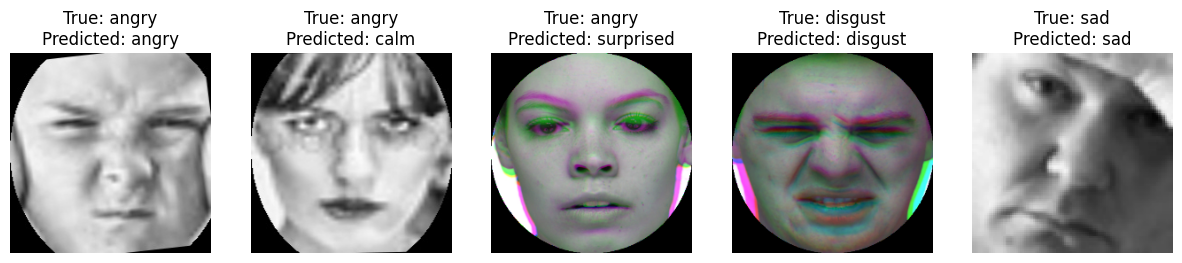

In [20]:
import matplotlib.pyplot as plt
import numpy as np


# Needs to be modified depending of used dataset
if nr_classes == 7:
    label_map = {
        0: "calm",
        1: "happy",
        2: "sad",
        3: "angry",
        4: "fearful",
        5: "disgust",
        6: "surprised"
    }
elif nr_classes == 8:
    label_map = {
        0: "neutral",
        1: "calm",
        2: "happy",
        3: "sad",
        4: "angry",
        5: "fearful",
        6: "disgust",
        7: "surprised"
    }    
elif nr_classes == 6:
    label_map = {
        1: "calm",
        2: "happy",
        3: "sad",
        4: "angry",
        5: "fearful",
        6: "surprised"
    }    
else:
    label_map = {
        0: "confussion",
        1: "happines",
        2: "neutral",
        3: "surprise"
    }

# Get a batch of images and labels from the test dataset
batch_images, batch_labels = next(iter(fer_test_data))

# Make predictions using the trained model
batch_predictions = model.predict(batch_images)
batch_predicted_labels = np.argmax(batch_predictions, axis=1)

# Plot example images with true and predicted labels
plt.figure(figsize=(15, 8))
for i in range(5):  # Plot 5 example images
    plt.subplot(1, 5, i + 1)
    plt.imshow(batch_images[i])
    true_label =  label_map[np.argmax(batch_labels[i])]
    predicted_label = label_map[batch_predicted_labels[i]]
    plt.title(f'True: {true_label}\nPredicted: {predicted_label}')
    plt.axis('off')
plt.show()


In [21]:
# Evaluate the model on the test dataset
loss, accuracy = model.evaluate(fer_test_data, verbose=0)
print(f'Test accuracy: {accuracy}')

Test accuracy: 0.6467642188072205


### Print confussion matrix

1/1 [==============================] - 0s 412ms/step


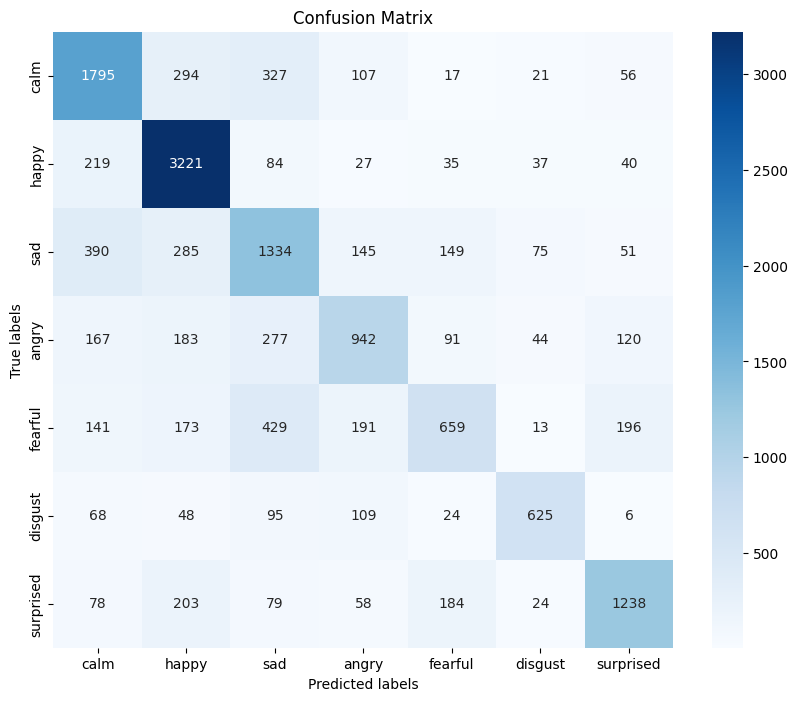

In [22]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Initialize empty lists to store all predictions and true labels
all_predictions = []
all_true_labels = []

# Calculate the total number of batches
total_batches = len(fer_test_data)

# Iterate over all batches in the test dataset
for batch_index in range(total_batches):
    batch_images, batch_labels = fer_test_data[batch_index]
    # Make predictions using the trained model for the current batch
    batch_predictions = model.predict(batch_images)
    # Get predicted labels for the batch
    batch_predicted_labels = np.argmax(batch_predictions, axis=1)
    # Convert batch_labels to numpy array and get the true labels
    batch_true_labels = np.argmax(np.array(batch_labels), axis=1)
    # Append the batch predictions and true labels to the respective lists
    all_predictions.extend(batch_predicted_labels)
    all_true_labels.extend(batch_true_labels)

# Convert lists to numpy arrays
all_predictions = np.array(all_predictions)
all_true_labels = np.array(all_true_labels)

# Calculate confusion matrix
conf_matrix = confusion_matrix(all_true_labels, all_predictions)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_map.values(), yticklabels=label_map.values())
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


# Save model to h5 file and crate zip link to download

In [23]:
model.save('/kaggle/working/model.h5')

In [25]:
import os
from zipfile import ZipFile
from IPython.display import FileLink

# Directory containing the file to be downloaded
directory_to_compress = '/kaggle/working'

# Name of the file to be downloaded
file_to_download = 'model.h5'  

# Temporary zip file path
zip_file_path = 'model.zip'

# Compress the specific file into a zip file
with ZipFile(zip_file_path, 'w') as zipf:
    zipf.write(os.path.join(directory_to_compress, file_to_download), file_to_download)

# Display download link for the zip file containing the specific file
FileLink(zip_file_path)

/kaggle/working/model.zip